In [91]:
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
from numpy.random import randint, random
import scipy.stats
import math
import cv2
import imageio

from sklearn import cluster
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
from scipy import ndimage
%matplotlib inline

# input fllename >> output 3d array
def read_img(filename, mode, size):
    if mode == 'RGB':
        img_3d = imageio.imread(filename)
    elif mode == 'L':
        img_3d = imageio.imread(filename, mode = 'L')
    # Downsample the image
    small = cv2.resize(img_3d, (0, 0), fx = size[0], fy = size[1])
    # Blurring effect to denoise
    blur = cv2.blur(small, (4, 4))
    return blur


# input 3d array >> output 2d array
def flatten_img(img_3d, mode):
    if mode == 'RGB':
        x, y, z = img_3d.shape
        img_2d = img_3d.reshape(x*y, z)
        img_2d = np.array(img_2d, dtype = np.float)
    elif mode == 'L':
        x, y = img_3d.shape
        img_2d = img_3d.reshape(x*y, 1)
        img_2d = np.array(img_2d, dtype = np.float)
    return img_2d


# input 2d array >> output 3d array
def recover_img(img_2d, X, Y, mode = 'RGB', vis = False):
    #img_2d = cv2.resize(img_2d, (0, 0), fx=10, fy=10)
    if mode == 'RGB':
        img_2d = (img_2d * 255).astype(np.uint8)
        recover_img = img_2d.reshape(X, Y, 3)
    elif mode == 'L':
        recover_img = img_2d.reshape(X, Y)
    return recover_img


# input 2d array >> output estimated means, stds, pis
def kmeans_init(img, k):
    means, labels = kmeans2(img, k)
    try:
        means = np.array(means)
        cov = np.array([np.cov(img[labels == i].T) for i in range(k)])
        ids = set(labels)
        pis = np.array([np.sum([labels == i]) / len(labels) for i in ids])
    except Exception as ex:
        pass
    return means, cov, pis

def random_init(img, k):
    # For gray-scale
    if len(img.shape) == 1:
        means = randint(low = 0, high = 255, size = (k,1))
        cov = randint(low = 0, high = 500, size = k)
        pis = random(size = k)
    else:
        z = img.shape[1]
        means = randint(low = 0, high = 255, size = (k , z))
        pre_cov = randint(low=0, high=2, size=img.shape[0])
        cov = np.array([np.cov(img[pre_cov == i].T) for i in range(k)])
        pis = random(size = k)
    return means, cov, pis


# E-Step: Update Parameters
# update the conditional pdf - prob that pixel i given class j
def update_responsibility(img, means, cov, pis, k):
    # responsibilities: i th pixels, j th class
    # pis * gaussian.pdf
    responsibilities = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)]).T
    # normalize for each row
    norm = np.sum(responsibilities, axis = 1)
    # convert to column vector
    norm = np.reshape(norm, (len(norm), 1))
    responsibilities = responsibilities / norm
    return responsibilities


# update pi for each class of Gaussian model
def update_pis(responsibilities):
    pis = np.sum(responsibilities, axis = 0) / responsibilities.shape[0]
    return pis

# update means for each class of Gaussian model
def update_means(img, responsibilities):
    means = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        means_j = weight.dot(img)
        means.append(means_j[0])
    means = np.array(means)
    return means

# update covariance matrix for each class of Gaussian model
def update_covariance(img, responsibilities, means):
    cov = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        # Each pixels have a covariance matrice
        covs = [np.mat(i - means[j]).T * np.mat(i - means[j]) for i in img]
        # Weighted sum of covariance matrices
        cov_j = sum(weight[0][i] * covs[i] for i in range(len(weight[0])))
        cov.append(cov_j)
    cov = np.array(cov)
    return cov


# M-step: choose a label that maximise the likelihood
def update_labels(responsibilities):
    labels = np.argmax(responsibilities, axis = 1)
    return labels


def update_loglikelihood(img, means, cov, pis, k):
    pdf = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)])
    log_ll = np.log(np.sum(pdf, axis = 0))
    log_ll_sum = np.sum(log_ll)
    return log_ll_sum


def EM_cluster(img, k, random = False, error = 10e-4, iter_n = 9999):
    #  init setting
    cnt = 0
    likelihood_arr = []
    means_arr = []
    if not random:
        # Initialise E-Step by KMeans
        means, cov, pis = kmeans_init(img, k)
    else:
        means, cov, pis = random_init(img, k)
    #print(means, cov, pis)
    likelihood = 0
    new_likelihood = 2
    means_arr.append(means)
    responsibilities = update_responsibility(img, means, cov, pis, k)
    while (abs(likelihood - new_likelihood) > error) and (cnt != iter_n):
        start_dt = datetime.datetime.now()
        cnt += 1
        likelihood = new_likelihood
        # M-Step
        labels = update_labels(responsibilities)
        # E-step
        responsibilities = update_responsibility(img, means, cov, pis, k)
        means = update_means(img, responsibilities)
        cov = update_covariance(img, responsibilities, means)
        pis = update_pis(responsibilities)
        new_likelihood = update_loglikelihood(img, means, cov, pis, k)
        likelihood_arr.append(new_likelihood)
        end_dt = datetime.datetime.now()
        diff = relativedelta(end_dt, start_dt)
        print("iter: %s, time interval: %s:%s:%s:%s" % (cnt, diff.hours, diff.minutes, diff.seconds, diff.microseconds))
        print("log-likelihood = {}".format(new_likelihood))
        # Store means stat
        means_arr.append(means)
    likelihood_arr = np.array(likelihood_arr)
    print('Converge at iteration {}'.format(cnt + 1))
    return labels, means, cov, pis, likelihood_arr, means_arr

In [50]:
def get_pdf(y, means, cov, pis, k):
    pdf_arr = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(y, mean=means[j], cov=cov[j]) for j in range(k)])
    pdf = np.sum(pdf_arr)
    return pdf

In [51]:
FILENAME_LIST = ['./img/lion.jpg', './img/fox.jpg', './img/hybrid.jpg']

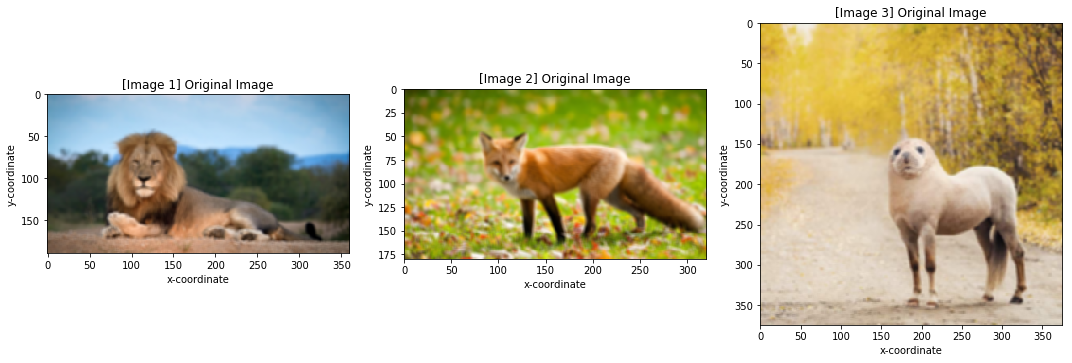

In [52]:
# Visualize demo images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
rgb_img_list = []
dim_img_list = []
i = 1
for filename, ax in zip(FILENAME_LIST, ax_list):
    rgb_img = read_img(filename = filename, mode = 'RGB', size = (0.5, 0.5))
    x, y, z = rgb_img.shape
    # Store dimension for each image
    dim_img_list.append((x,y,z))
    # Store img 
    rgb_img_list.append(rgb_img)
    ax.imshow(rgb_img)
    ax.set_title('[Image {}] Original Image'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1;

plt.tight_layout()
fig.savefig('orig_images.pdf')

## GET K-MEANS IMAGES - K=2

In [66]:
img_list = [flatten_img(image, mode = 'RGB') for image in rgb_img_list]

In [69]:
# Run and Store KMeans image
from sklearn import cluster
from scipy.cluster.vq import kmeans2
kmeans_img_list = []

for img, dim in zip(img_list, dim_img_list):
    k_means, k_labels = kmeans2(img, 2)
    k_means, k_labels
    kmeans_img = np.array([i[0] for i in k_means[k_labels]])
    kmeans_img = kmeans_img.reshape(dim[0], dim[1])
    kmeans_img_list.append(kmeans_img)


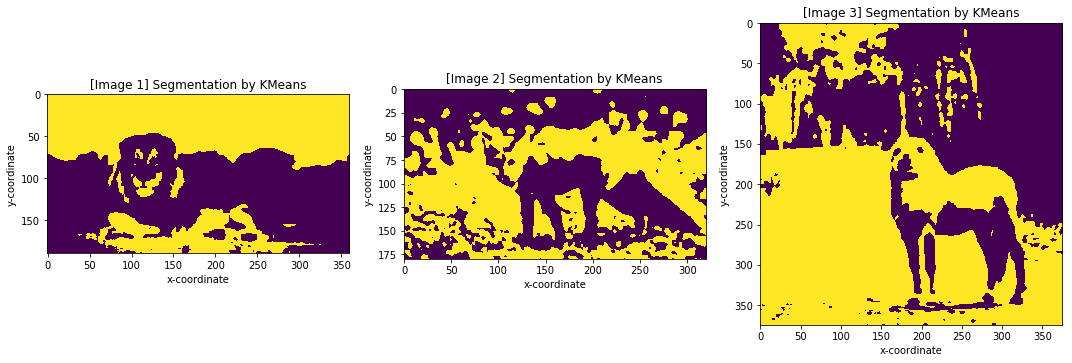

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
for kmeans_img, ax, dim in zip(kmeans_img_list, ax_list, dim_img_list):
    ax.imshow(kmeans_img)
    ax.set_title('[Image {}] Segmentation by KMeans'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1;
    
plt.tight_layout()
fig.savefig('kmeans_images.pdf')

## GET EM (WITH KMEANS INIT) IMAGES AND STAT - K=2

In [72]:
# Init container
likelihood_arr_list = []
means_arr_list = []
cov_arr_list = []
pis_arr_list = []
em_img_list = []
means_list = []

for img, dim in zip(img_list, dim_img_list):
    labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(img, 2, error = 0.001)
    means = np.array([element[0] for element in means])
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    recover_img = em_img.reshape(dim[0], dim[1])
    # store required stat
    likelihood_arr_list.append(likelihood_arr)
    means_arr_list.append(means_arr)
    cov_arr_list.append(cov)
    pis_arr_list.append(pis)
    em_img_list.append(recover_img)
    means_list.append(means)

iter: 1, time interval: 0:0:6:559375
log-likelihood = -898108.2235243949
iter: 2, time interval: 0:0:6:461370
log-likelihood = -897161.6553951417
iter: 3, time interval: 0:0:6:538374
log-likelihood = -896714.8278873498
iter: 4, time interval: 0:0:6:408367
log-likelihood = -896327.339435102
iter: 5, time interval: 0:0:6:401366
log-likelihood = -895786.724763742
iter: 6, time interval: 0:0:6:401366
log-likelihood = -894800.0791042349
iter: 7, time interval: 0:0:6:219356
log-likelihood = -892767.2740670529
iter: 8, time interval: 0:0:6:499371
log-likelihood = -888626.9576078173
iter: 9, time interval: 0:0:6:509373
log-likelihood = -882223.2222384869
iter: 10, time interval: 0:0:6:581376
log-likelihood = -877837.7227693236
iter: 11, time interval: 0:0:6:535374
log-likelihood = -876820.1827627465
iter: 12, time interval: 0:0:6:762387
log-likelihood = -876529.4251773416
iter: 13, time interval: 0:0:6:984399
log-likelihood = -876445.5503829652
iter: 14, time interval: 0:0:6:409367
log-likelih

iter: 90, time interval: 0:0:5:695326
log-likelihood = -830460.1180280269
iter: 91, time interval: 0:0:5:434311
log-likelihood = -830446.3468115315
iter: 92, time interval: 0:0:5:495314
log-likelihood = -830436.1730523573
iter: 93, time interval: 0:0:5:462313
log-likelihood = -830428.6580729332
iter: 94, time interval: 0:0:5:489314
log-likelihood = -830423.1303144613
iter: 95, time interval: 0:0:5:506315
log-likelihood = -830419.0797402816
iter: 96, time interval: 0:0:5:476313
log-likelihood = -830416.1142339883
iter: 97, time interval: 0:0:5:514315
log-likelihood = -830413.9390150434
iter: 98, time interval: 0:0:5:504315
log-likelihood = -830412.3380058319
iter: 99, time interval: 0:0:5:416310
log-likelihood = -830411.1551399791
iter: 100, time interval: 0:0:5:619321
log-likelihood = -830410.2781604653
iter: 101, time interval: 0:0:5:418310
log-likelihood = -830409.62610105
iter: 102, time interval: 0:0:5:646323
log-likelihood = -830409.14021212
iter: 103, time interval: 0:0:5:460313


In [73]:
# Store density estimate (i.e pdf)
pdf_arr_list = []
for em_img, means, cov, pis in zip(em_img_list, means_list, cov_arr_list, pis_arr_list):
    pdf_arr = [get_pdf(i, means, cov, pis, 2) for i in np.linspace(0, 255, 256)]
    pdf_arr_list.append(pdf_arr)

D:\Project\web_crawler\venv\lib\site-packages\matplotlib\axes\_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


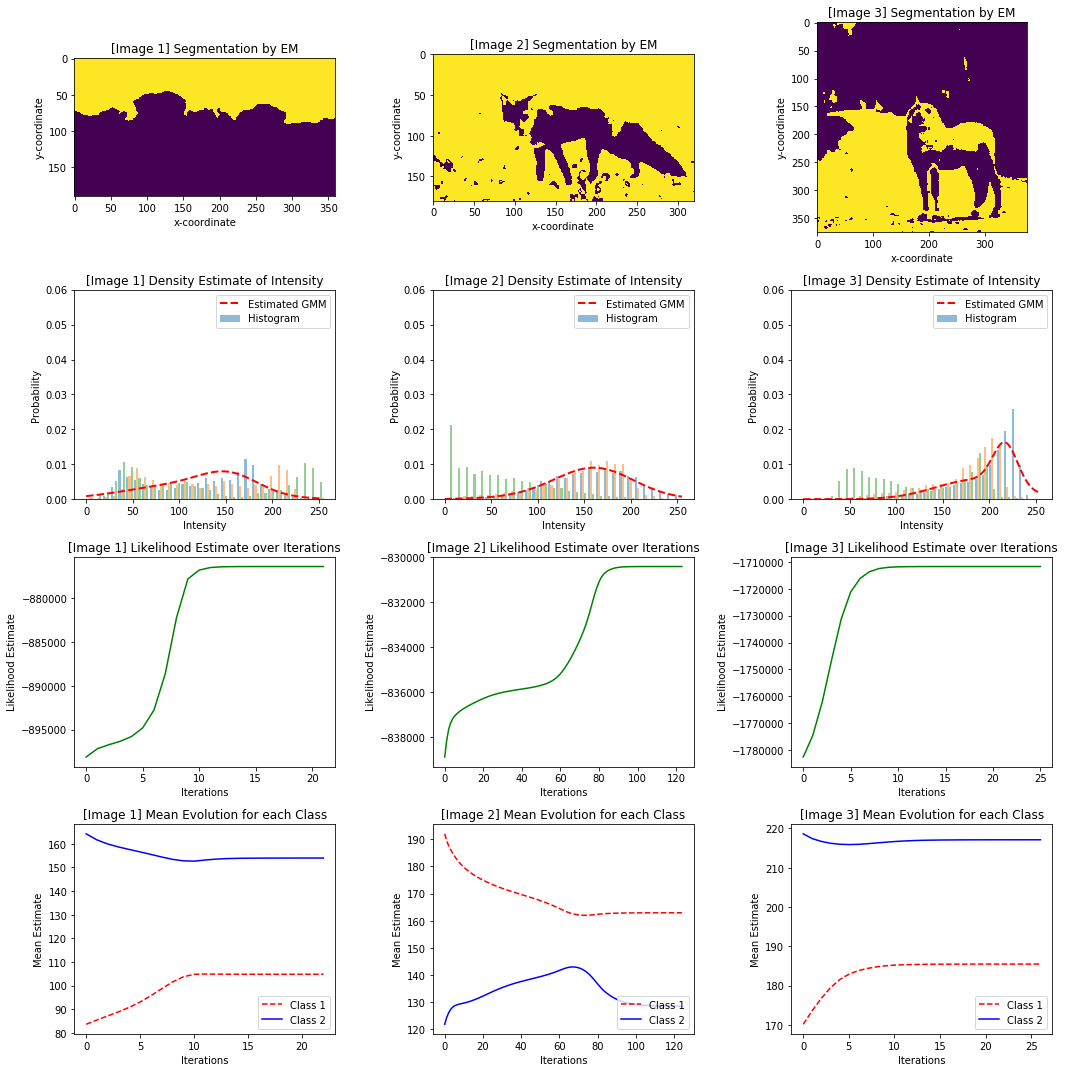

In [74]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
# FIRST ROW: display image segment
for em_img, ax in zip(em_img_list, ax_list):
    ax.imshow(em_img)
    ax.set_title('[Image {}] Segmentation by EM'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1;

# SECOND ROW: display density estimate
ax_list = [ax4, ax5, ax6]
i = 1
for img, pdf, ax in zip(img_list, pdf_arr_list, ax_list):
    ax.hist(img, bins = 30, normed = True, alpha = 0.5, label='Histogram')
    ax.plot(pdf, 'r--', linewidth = 2, label = 'Estimated GMM')
    ax.set_title('[Image {}] Density Estimate of Intensity'.format(i))
    ax.legend()
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Intensity')
    ax.axes.set_ylabel('Probability')
    # Strink the y-axis
    ax.set_ylim(0, 0.06)    
    i += 1;
    
# THIRD ROW: density estimate
ax_list = [ax7, ax8, ax9]
i = 1
for ll, ax in zip(likelihood_arr_list, ax_list):
    ax.plot(ll, 'g-')
    ax.set_title('[Image {}] Likelihood Estimate over Iterations'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Iterations')
    ax.axes.set_ylabel('Likelihood Estimate')
    i += 1

# FOURTH ROW: displays means evolution over iteration
ax_list = [ax10, ax11, ax12]
i = 1
for m, ax in zip(means_arr_list, ax_list):
    # The 2nd image has class label inversed
    if i == 2:
        # Remove inner index
        m1 = [i[1][0] for i in m]
        m2 = [i[0][0] for i in m]
    else:       
        m1 = [i[0][0] for i in m]
        m2 = [i[1][0] for i in m]
    ax.plot(m1, 'r--', label = 'Class 1')
    ax.plot(m2, 'b-', label = 'Class 2')
    ax.set_title('[Image {}] Mean Evolution for each Class'.format(i))
    ax.legend(loc = 4)
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Iterations')
    ax.axes.set_ylabel('Mean Estimate')
    i += 1

# Make a nice layout
plt.tight_layout();
plt.savefig("em_kmeans_init.pdf")

## GET EM (WITH RANDOM INIT) IMAGES AND STAT - K=2

In [92]:
# Init container
rand_likelihood_arr_list = []
rand_means_arr_list = []
rand_cov_arr_list = []
rand_pis_arr_list = []
rand_em_img_list = []
rand_means_list = []

for img, dim in zip(img_list, dim_img_list):
    labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(img, 2, random = True, error = 0.001)
    means = np.array([element[0] for element in means])
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    recover_img = em_img.reshape(dim[0], dim[1])
    # store required stat
    rand_likelihood_arr_list.append(likelihood_arr)
    rand_means_arr_list.append(means_arr)
    rand_cov_arr_list.append(cov)
    rand_pis_arr_list.append(pis)
    rand_em_img_list.append(recover_img)
    rand_means_list.append(means)

iter: 1, time interval: 0:0:6:794389
log-likelihood = -944592.386028141
iter: 2, time interval: 0:0:6:482371
log-likelihood = -944592.386028141
Converge at iteration 3
iter: 1, time interval: 0:0:5:579319
log-likelihood = -838667.4722765447
iter: 2, time interval: 0:0:5:766330
log-likelihood = -833936.0637738121
iter: 3, time interval: 0:0:5:446311
log-likelihood = -832144.315775009
iter: 4, time interval: 0:0:5:709327
log-likelihood = -831360.6739659195
iter: 5, time interval: 0:0:5:565318
log-likelihood = -830954.1298553832
iter: 6, time interval: 0:0:5:663324
log-likelihood = -830734.3294037607
iter: 7, time interval: 0:0:5:663324
log-likelihood = -830611.5270023054
iter: 8, time interval: 0:0:5:715327
log-likelihood = -830541.0822434823
iter: 9, time interval: 0:0:5:807332
log-likelihood = -830496.6230313801
iter: 10, time interval: 0:0:5:706327
log-likelihood = -830467.3059908283
iter: 11, time interval: 0:0:5:705326
log-likelihood = -830448.6531256604
iter: 12, time interval: 0:0

In [93]:
# Store density estimate (i.e pdf)
rand_pdf_arr_list = []
for em_img, means, cov, pis in zip(rand_em_img_list, rand_means_list, rand_cov_arr_list, rand_pis_arr_list):
    rand_pdf_arr = [get_pdf(i, means, cov, pis, 2) for i in np.linspace(0, 255, 256)]
    rand_pdf_arr_list.append(rand_pdf_arr)

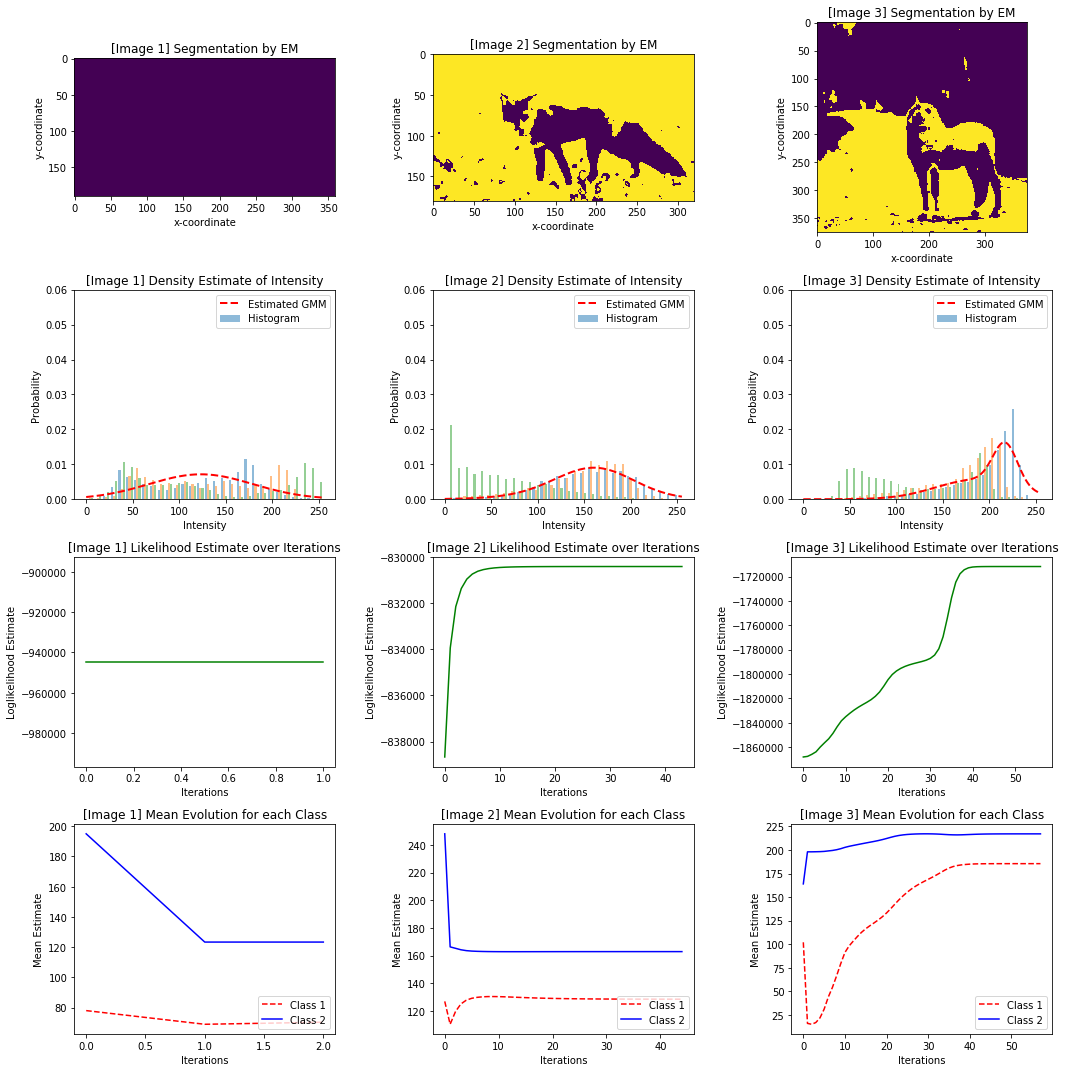

In [95]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
# FIRST ROW: display image segment
for rand_em_img, ax in zip(rand_em_img_list, ax_list):
    ax.imshow(rand_em_img)
    ax.set_title('[Image {}] Segmentation by EM'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1;

# SECOND ROW: display density estimate
ax_list = [ax4, ax5, ax6]
i = 1
for img, pdf, ax in zip(img_list, rand_pdf_arr_list, ax_list):
    ax.hist(img, bins = 30, normed = True, alpha = 0.5, label='Histogram')
    ax.plot(pdf, 'r--', linewidth = 2, label = 'Estimated GMM')
    ax.set_title('[Image {}] Density Estimate of Intensity'.format(i))
    ax.legend()
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Intensity')
    ax.axes.set_ylabel('Probability')
    # Strink the y-axis
    ax.set_ylim(0, 0.06)    
    i += 1;
    
# THIRD ROW: loglikelihood estimate
ax_list = [ax7, ax8, ax9]
i = 1
for ll, ax in zip(rand_likelihood_arr_list, ax_list):
    ax.plot(ll, 'g-')
    ax.set_title('[Image {}] Likelihood Estimate over Iterations'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Iterations')
    ax.axes.set_ylabel('Loglikelihood Estimate')
    i += 1

# FOURTH ROW: displays means evolution over iteration
ax_list = [ax10, ax11, ax12]
i = 1
for m, ax in zip(rand_means_arr_list, ax_list):
    # The 1st image has class label inversed
    if i == 1:
        # Remove inner index
        m1 = [i[1][0] for i in m]
        m2 = [i[0][0] for i in m]
    else:       
        m1 = [i[0][0] for i in m]
        m2 = [i[1][0] for i in m]
    ax.plot(m1, 'r--', label = 'Class 1')
    ax.plot(m2, 'b-', label = 'Class 2')
    ax.set_title('[Image {}] Mean Evolution for each Class'.format(i))
    ax.legend(loc = 4)
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Iterations')
    ax.axes.set_ylabel('Mean Estimate')
    i += 1

# Make a nice layout
plt.tight_layout();
fig.savefig('em_rand_init.pdf')

## ADD NOISE DEMO

In [101]:
import numpy as np
import random
import cv2

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

image = read_img('./img/hybrid.jpg', mode = 'RGB', size = (0.6, 0.6)) 
noise_img = sp_noise(image,0.1)
x, y, z = noise_img.shape

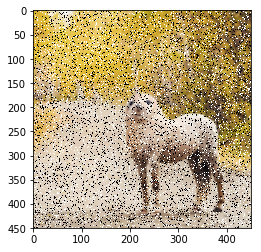

In [102]:
plt.imshow(noise_img);

iter: 1, time interval: 0:0:20:50147
log-likelihood = -2675469.5030235695
iter: 2, time interval: 0:0:20:523174
log-likelihood = -2674472.539701533
iter: 3, time interval: 0:0:19:569119
log-likelihood = -2674005.5543722347
iter: 4, time interval: 0:0:20:532175
log-likelihood = -2673717.977753575
iter: 5, time interval: 0:0:18:975085
log-likelihood = -2673503.435857831
iter: 6, time interval: 0:0:19:88092
log-likelihood = -2673322.664861379
iter: 7, time interval: 0:0:19:281103
log-likelihood = -2673156.1343905306
iter: 8, time interval: 0:0:19:526117
log-likelihood = -2672990.873921061
iter: 9, time interval: 0:0:19:159096
log-likelihood = -2672816.098736318
iter: 10, time interval: 0:0:18:957084
log-likelihood = -2672621.4193597916
iter: 11, time interval: 0:0:18:946084
log-likelihood = -2672396.128841511
iter: 12, time interval: 0:0:19:845135
log-likelihood = -2672129.2643887056
iter: 13, time interval: 0:0:19:405110
log-likelihood = -2671810.2609287263
iter: 14, time interval: 0:0:1

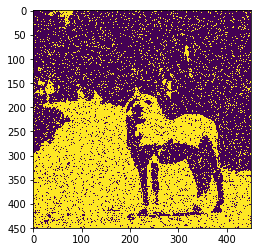

In [104]:
flat_img =  flatten_img(noise_img, mode = 'RGB')
labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(flat_img, 2, error = 0.001)
means = np.array([element[0] for element in means])
cov = [element[0][0] for element in cov]
em_img = means[labels]
recover_img_1 = em_img.reshape(x, y)
plt.imshow(recover_img_1);

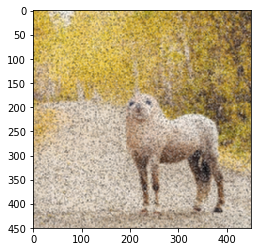

In [105]:
blur_img = cv2.blur(noise_img, (4, 4))
plt.imshow(blur_img);

iter: 1, time interval: 0:0:18:968085
log-likelihood = -2540340.6489199707
iter: 2, time interval: 0:0:19:170096
log-likelihood = -2526653.481606483
iter: 3, time interval: 0:0:18:359050
log-likelihood = -2507126.900226652
iter: 4, time interval: 0:0:18:440054
log-likelihood = -2482086.2799292826
iter: 5, time interval: 0:0:18:296047
log-likelihood = -2457214.57205147
iter: 6, time interval: 0:0:18:441055
log-likelihood = -2440386.4383418947
iter: 7, time interval: 0:0:18:589063
log-likelihood = -2433374.673303803
iter: 8, time interval: 0:0:18:482057
log-likelihood = -2431007.070367778
iter: 9, time interval: 0:0:18:497058
log-likelihood = -2430236.162914903
iter: 10, time interval: 0:0:18:490058
log-likelihood = -2429962.531789059
iter: 11, time interval: 0:0:18:552061
log-likelihood = -2429855.5192163563
iter: 12, time interval: 0:0:18:277045
log-likelihood = -2429811.360295286
iter: 13, time interval: 0:0:18:449055
log-likelihood = -2429792.7200214015
iter: 14, time interval: 0:0:1

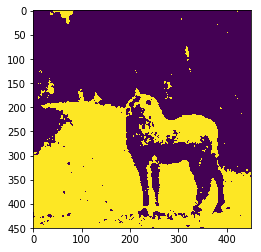

In [106]:
flat_img =  flatten_img(blur_img, mode = 'RGB')
labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(flat_img, 2, error = 0.001)
means = np.array([element[0] for element in means])
cov = [element[0][0] for element in cov]
em_img = means[labels]
recover_img_2 = em_img.reshape(x, y)
plt.imshow(recover_img_2);

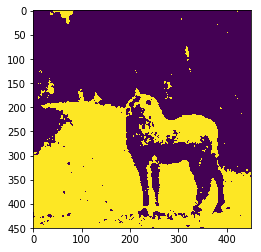

In [107]:
recover_img = em_img.reshape(x, y)
plt.imshow(recover_img);

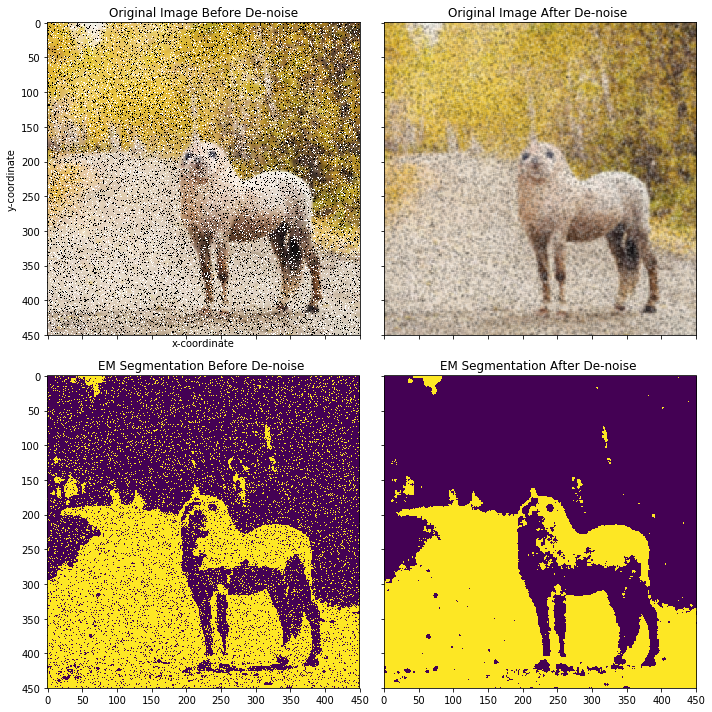

In [108]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (10,10))

ax1.imshow(noise_img)
ax1.set_title('Original Image Before De-noise')

ax2.imshow(blur_img)
ax2.set_title('Original Image After De-noise ')

ax3.imshow(recover_img_1)
ax3.set_title('EM Segmentation Before De-noise ')

ax4.imshow(recover_img_2)
ax4.set_title('EM Segmentation After De-noise ')

ax1.axes.set_xlabel('x-coordinate')
ax1.axes.set_ylabel('y-coordinate')

# SECOND ROW: log-likelihood evolution

plt.tight_layout()
fig.savefig('denoise_compare.pdf')

In [110]:
iter_num = [1, 10, 25]
demo_img_list = []
for n in iter_num:
    labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(flat_img, 2, error = 0.001, iter_n = n)
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    tmp_img = em_img.reshape(x, y,z)
    demo_img_list.append(tmp_img)

iter: 1, time interval: 0:0:18:551061
log-likelihood = -2539535.2322168765
Converge at iteration 2
iter: 1, time interval: 0:0:19:260101
log-likelihood = -2540137.529289802
iter: 2, time interval: 0:0:20:713185
log-likelihood = -2526263.8309836453
iter: 3, time interval: 0:0:20:357165
log-likelihood = -2506505.767404947
iter: 4, time interval: 0:0:20:773188
log-likelihood = -2481340.6767707695
iter: 5, time interval: 0:0:20:274159
log-likelihood = -2456579.584975542
iter: 6, time interval: 0:0:20:124151
log-likelihood = -2440060.4181843777
iter: 7, time interval: 0:0:19:286103
log-likelihood = -2433259.2259872523
iter: 8, time interval: 0:0:19:403110
log-likelihood = -2430969.2101151403
iter: 9, time interval: 0:0:19:933140
log-likelihood = -2430223.169298764
iter: 10, time interval: 0:0:20:840135
log-likelihood = -2429957.5833634273
Converge at iteration 11
iter: 1, time interval: 0:0:21:154210
log-likelihood = -2539406.763381272
iter: 2, time interval: 0:0:20:612179
log-likelihood = 

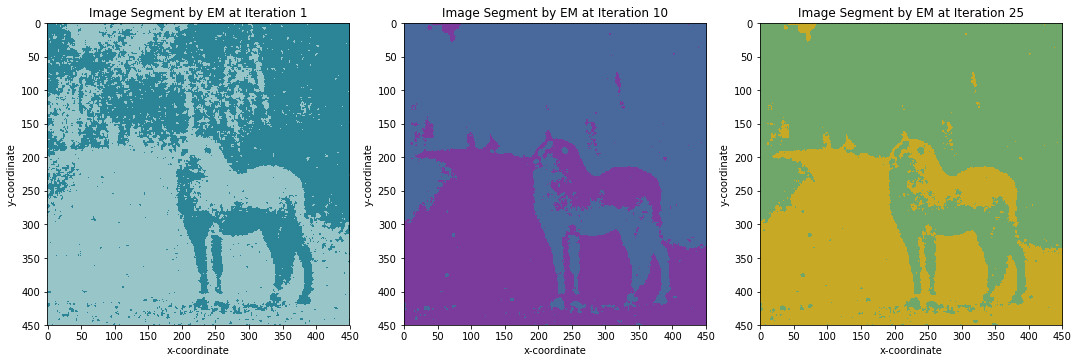

In [115]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
# FIRST ROW: display image segment
for demo_img, n, ax in zip(demo_img_list, iter_num, ax_list):
    demo_img = (demo_img * 255).astype(np.uint8)
    ax.imshow(demo_img)
    ax.set_title('Image Segment by EM at Iteration {}'.format(n))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1;

plt.tight_layout()
fig.savefig('EM_iterations.pdf')